# Monoclonal Antibody Trial Success Prediction - Data Exploration

This notebook explores clinical trial data to predict Phase 2/3 success for monoclonal antibody therapies.

**Data source:** ClinicalTrials.gov API  
**Target:** Binary classification of trial outcomes (success/failure)

In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading (Clean Labels Dataset)

We'll load the labeled Phase 2/3 monoclonal antibody trials with **Clean Labels** (excludes administrative terminations). This dataset (`data/clinical_trials_binary.csv`) is used for modeling and EDA reports.

**Labeling Strategy**: Trials terminated for administrative reasons (funding, enrollment, business decisions) are excluded to focus on clinical efficacy prediction. See `docs/LABELING_STRATEGY_DECISION.md` for details.

In [ ]:
from pathlib import Path

DATA_DIR = Path('../data')
DATA_FILE = DATA_DIR / 'clinical_trials_binary.csv'

if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"{DATA_FILE} not found. Run src/data_labeling.py to generate labeled data."
    )

# Load labeled data with Clean Labels strategy
print('Loading labeled clinical trial data with Clean Labels strategy...')
df = pd.read_csv(DATA_FILE)

print(f"✓ Loaded {len(df):,} trials from {DATA_FILE.name}")
print(f"  - Successful trials: {(df['binary_outcome'] == 1).sum():,} ({(df['binary_outcome'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"  - Failed trials: {(df['binary_outcome'] == 0).sum():,} ({(df['binary_outcome'] == 0).sum() / len(df) * 100:.1f}%)")
print(f"\nDataset ready for exploration with {df.shape[0]:,} rows and {df.shape[1]} columns")
print(f"\nNote: This dataset excludes 879 trials (12.4% of raw data) terminated for")
print(f"      administrative reasons to focus on clinical efficacy prediction.")

In [3]:
print(f"Data source: {RAW_DATA_FILE}")
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Data source: ../data/completed_phase2_3_trials.csv
DataFrame shape: (7116, 31)
Columns: ['nct_id', 'brief_title', 'official_title', 'overall_status', 'why_stopped', 'phase', 'study_type', 'enrollment', 'conditions', 'intervention_names', 'antibody_type', 'sponsor_class', 'sponsor_name', 'start_date', 'completion_date', 'primary_completion_date', 'has_results', 'allocation', 'intervention_model', 'primary_purpose', 'masking', 'gender', 'minimum_age', 'maximum_age', 'num_locations', 'num_countries', 'countries', 'keywords', 'is_antibody', 'antibody_name', 'phases']


## 2. Initial Data Exploration

In [4]:
# Display first few rows
df.head(10)

,nct_id,brief_title,official_title,overall_status,why_stopped,phase,study_type,enrollment,conditions,intervention_names,antibody_type,sponsor_class,sponsor_name,start_date,completion_date,primary_completion_date,has_results,allocation,intervention_model,primary_purpose,masking,gender,minimum_age,maximum_age,num_locations,num_countries,countries,keywords,is_antibody,antibody_name,phases
0,NCT03197935,A Study to Investigate Atezolizumab and Chemot...,A Phase III Randomized Study to Investigate th...,Completed,NaN,Phase 3,Interventional,333,Triple-negative Breast Cancer,"Atezolizumab (MPDL3280A), an engineered anti-P...",unknown,Industry,Hoffmann-La Roche,"July 24, 2017","September 28, 2022","April 3, 2020",True,Randomized,Parallel Assignment,Treatment,"Double (Participant, Investigator)",All,18 Years,NaN,68,0,NaN,NaN,True,"Atezolizumab (MPDL3280A), an engineered anti-P...",Phase 3
1,NCT05067335,"A Study to Test the Efficacy, Safety and Toler...","A Multicenter, Randomized, Double-Blind, Place...",Completed,NaN,Phase 3,Interventional,327,Osteoporosis,Romosozumab; Placebo,humanized,Industry,UCB Biopharma SRL,"October 21, 2021","November 9, 2023","November 9, 2023",True,Randomized,Parallel Assignment,Treatment,"Quadruple (Participant, Care Provider, Investi...",Female,55 Years,90 Years,30,0,NaN,Osteoporosis; Phase 3; Chinese Patients; Romos...,True,Romosozumab,Phase 3
2,NCT00390208,Triple Therapy - PDT Plus IVD and Intravitreal...,A Prospective Masked Pilot Study Comparing Gro...,Completed,NaN,Phase 2,Interventional,60,Age Related Macular Degeneration,"ranibizumab, dexamethasone and verteporfin; Ra...",humanized,Other,Bay Area Retina Associates,August 2006,December 2009,December 2008,False,Randomized,Parallel Assignment,Treatment,Single (Outcomes Assessor),All,50 Years,NaN,4,0,NaN,Macular Degeneration; Degenerative changes in ...,True,Ranibizumab,Phase 2
3,NCT02882308,Preoperative Administration of Olaparib With C...,Phase II(Window) Preoperative Study of Olapari...,Completed,NaN,Phase 2,Interventional,41,Squamous Cell Carcinoma of the Head and Neck,Olaparib; Cisplatin; Olaparib; Durvalumab,fully_human,Other,Hellenic Cooperative Oncology Group,"October 20, 2016","January 10, 2020",December 2019,False,Randomized,Factorial Assignment,Treatment,None (Open Label),All,18 Years,NaN,2,0,NaN,NaN,True,Durvalumab,Phase 2
4,NCT01564108,"The LIMO Study, Lucentis for Treatment of Uvei...",An Exploratory Study of Ranibizumab (Lucentis)...,Completed,NaN,Phase 2,Interventional,10,Uveitis Related Cystoid Macular Edema; Steroid...,Ranibizumab,humanized,Other,Moorfields Eye Hospital NHS Foundation Trust,"May 1, 2012",June 2014,June 2014,False,NaN,Single Group Assignment,Treatment,None (Open Label),All,18 Years,75 Years,1,0,NaN,Intravitreal Ranibizumab; Non-infectious uveit...,True,Ranibizumab,Phase 2
5,NCT04513925,A Study of Atezolizumab and Tiragolumab Compar...,"A Phase III, Open-Label, Randomized Study of A...",Completed,NaN,Phase 3,Interventional,829,Non-small Cell Lung Cancer (NSCLC),Atezolizumab; Tiragolumab; Durvalumab,humanized,Industry,Hoffmann-La Roche,"August 24, 2020","July 31, 2025","May 27, 2025",False,Randomized,Parallel Assignment,Treatment,None (Open Label),All,18 Years,NaN,177,0,NaN,NaN,True,Atezolizumab,Phase 3
6,NCT04122625,Study to Assess Safety and Efficacy of the Sec...,"A Dose-optimization, Exploratory Phase Ib/II S...",Completed,NaN,Phase 1/Phase 2,Interventional,46,Solid Tumor,Debio 1143; Nivolumab,fully_human,Industry,Debiopharm International SA,"April 26, 2019","April 6, 2022","April 6, 2022",True,Non-Randomized,Sequential Assignment,Treatment,None (Open Label),All,18 Years,NaN,17,0,NaN,NaN,True,Nivolumab,Phase 1/Phase 2
7,NCT01453725,Effect of Golimumab in Participants With Activ...,"A Multicenter, Randomized, Double-blind, Place...",Completed,NaN,Phase 3,Interventional,198,"Spondylitis, Ankylosing",Golimumab; Placebo,fully_human,Industry,Merck Sharp & Dohme LLC,"February 13, 2012","January 15, 2015","March 11, 2014",True

In [5]:
# Basic information
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset Information:
Shape: (7116, 31)

Columns: ['nct_id', 'brief_title', 'official_title', 'overall_status', 'why_stopped', 'phase', 'study_type', 'enrollment', 'conditions', 'intervention_names', 'antibody_type', 'sponsor_class', 'sponsor_name', 'start_date', 'completion_date', 'primary_completion_date', 'has_results', 'allocation', 'intervention_model', 'primary_purpose', 'masking', 'gender', 'minimum_age', 'maximum_age', 'num_locations', 'num_countries', 'countries', 'keywords', 'is_antibody', 'antibody_name', 'phases']

Data types:
nct_id                      object
brief_title                 object
official_title              object
overall_status              object
why_stopped                 object
phase                       object
study_type                  object
enrollment                   int64
conditions                  object
intervention_names          object
antibody_type               object
sponsor_class               object
sponsor_name                object
s

In [6]:
# Summary statistics
df.describe()

,enrollment,num_locations,num_countries,countries
count,7116.000000,7116.000000,7116.0,0.0
mean,183.938589,32.800028,0.0,NaN
std,628.223945,81.050253,0.0,NaN
min,0.000000,0.000000,0.0,NaN
25%,17.000000,1.000000,0.0,NaN
50%,49.000000,4.000000,0.0,NaN
75%,149.000000,29.000000,0.0,NaN
max,27564.000000,1388.000000,0.0,NaN


## 3. Status Distribution

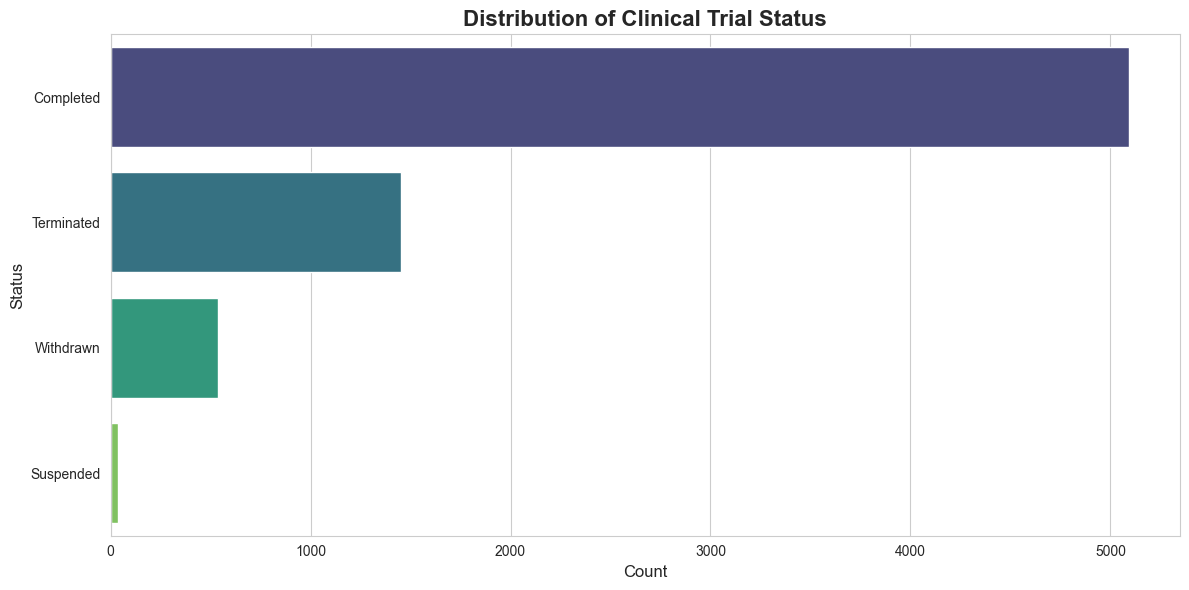


Status Distribution:
overall_status
Completed     5093
Terminated    1450
Withdrawn      536
Suspended       37
Name: count, dtype: int64


In [7]:
# Overall status distribution
plt.figure(figsize=(12, 6))
status_counts = df['overall_status'].value_counts()
sns.barplot(x=status_counts.values, y=status_counts.index, hue=status_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Clinical Trial Status', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.tight_layout()
plt.show()

print("\nStatus Distribution:")
print(status_counts)

## 4. Phase Distribution

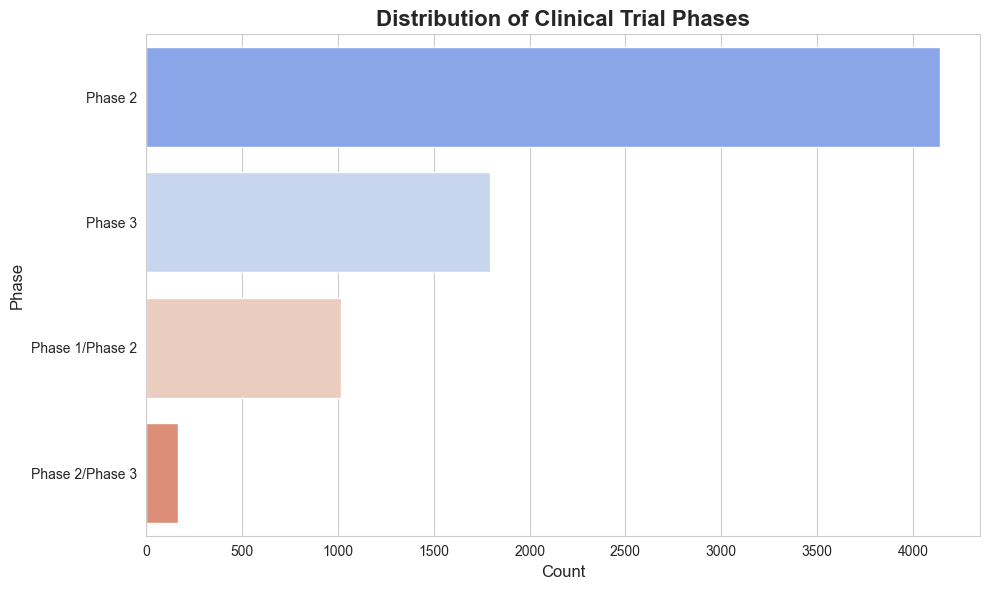


Phase Distribution:
phases
Phase 2            4143
Phase 3            1793
Phase 1/Phase 2    1016
Phase 2/Phase 3     164
Name: count, dtype: int64


In [8]:
# Phase distribution
plt.figure(figsize=(10, 6))
phase_counts = df['phases'].value_counts()
sns.barplot(x=phase_counts.values, y=phase_counts.index, hue=phase_counts.index, palette='coolwarm', legend=False)
plt.title('Distribution of Clinical Trial Phases', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Phase', fontsize=12)
plt.tight_layout()
plt.show()

print("\nPhase Distribution:")
print(phase_counts)

## 5. Sponsor Analysis

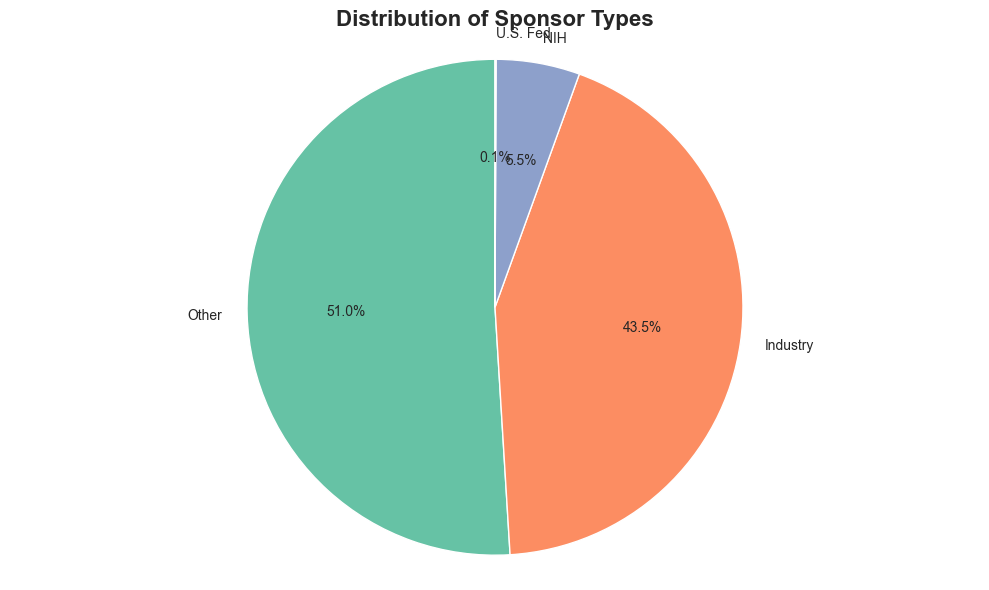


Sponsor Class Distribution:
sponsor_class
Other       3627
Industry    3096
NIH          388
U.S. Fed       5
Name: count, dtype: int64

Percentages:
sponsor_class
Other       50.969646
Industry    43.507589
NIH          5.452501
U.S. Fed     0.070264
Name: proportion, dtype: float64


In [9]:
# Sponsor class distribution
plt.figure(figsize=(10, 6))
sponsor_counts = df['sponsor_class'].value_counts()
colors = sns.color_palette('Set2', len(sponsor_counts))
plt.pie(sponsor_counts.values, labels=sponsor_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors)
plt.title('Distribution of Sponsor Types', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\nSponsor Class Distribution:")
print(sponsor_counts)
print(f"\nPercentages:")
print(df['sponsor_class'].value_counts(normalize=True) * 100)

## 6. Enrollment Analysis

Enrollment Statistics:
count     7116.000000
mean       183.938589
std        628.223945
min          0.000000
25%         17.000000
50%         49.000000
75%        149.000000
max      27564.000000
Name: enrollment, dtype: float64


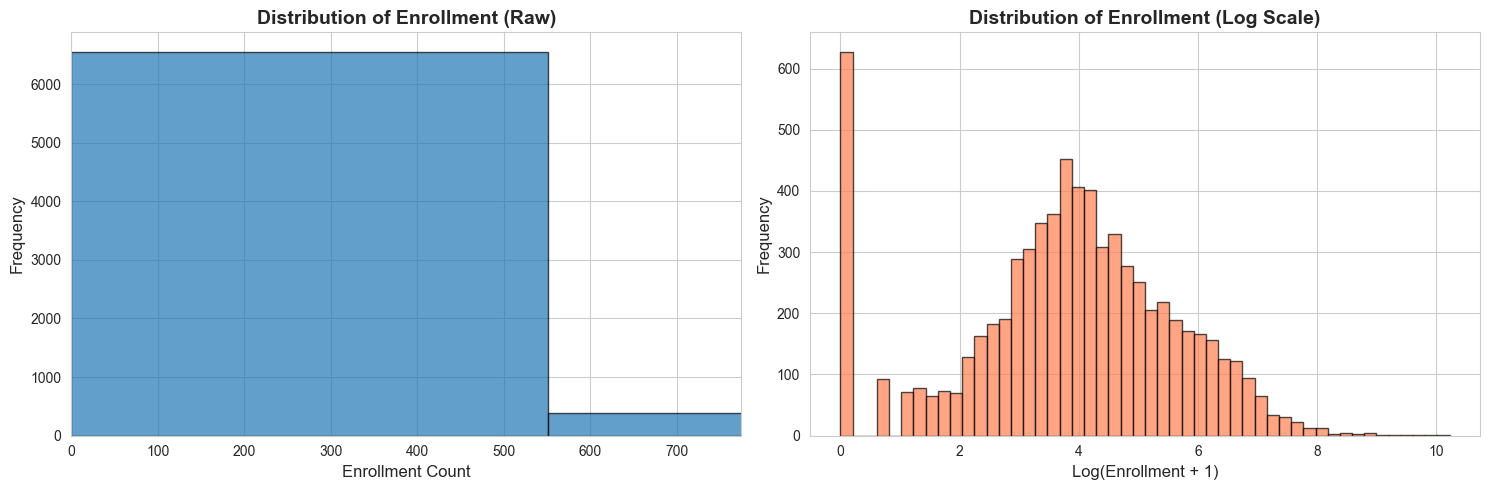

In [10]:
# Enrollment statistics
df['enrollment'] = pd.to_numeric(df['enrollment'], errors='coerce')

print("Enrollment Statistics:")
print(df['enrollment'].describe())

# Plot enrollment distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['enrollment'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Enrollment Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Enrollment (Raw)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, df['enrollment'].quantile(0.95))

# Log-scale histogram
axes[1].hist(np.log1p(df['enrollment'].dropna()), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Log(Enrollment + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Enrollment (Log Scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Temporal Analysis

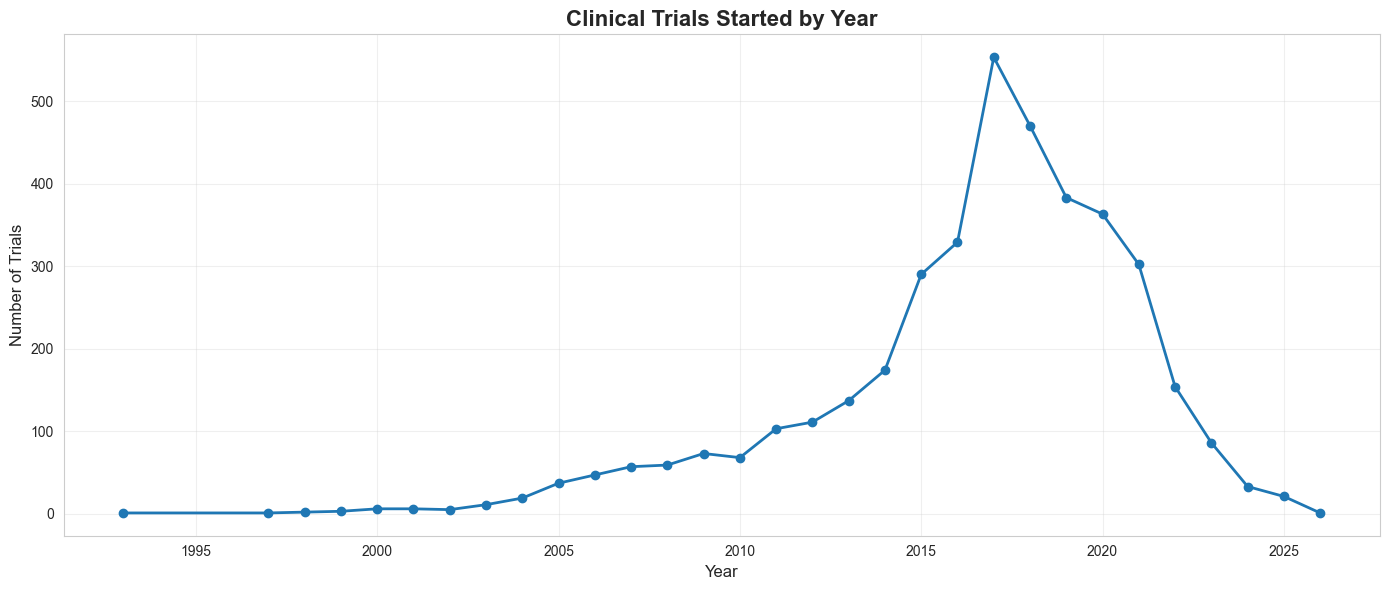


Trials by Decade:
decade
1990.0       7
2000.0     320
2010.0    2618
2020.0     960
Name: count, dtype: int64


In [11]:
# Convert dates
df['start_date_parsed'] = pd.to_datetime(df['start_date'], errors='coerce')
df['start_year'] = df['start_date_parsed'].dt.year

# Trials over time
plt.figure(figsize=(14, 6))
trials_by_year = df['start_year'].value_counts().sort_index()
plt.plot(trials_by_year.index, trials_by_year.values, marker='o', linewidth=2, markersize=6)
plt.title('Clinical Trials Started by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTrials by Decade:")
df['decade'] = (df['start_year'] // 10) * 10
print(df['decade'].value_counts().sort_index())

## 8. Condition Analysis

Total unique conditions: 3528

Top 20 Most Common Conditions:


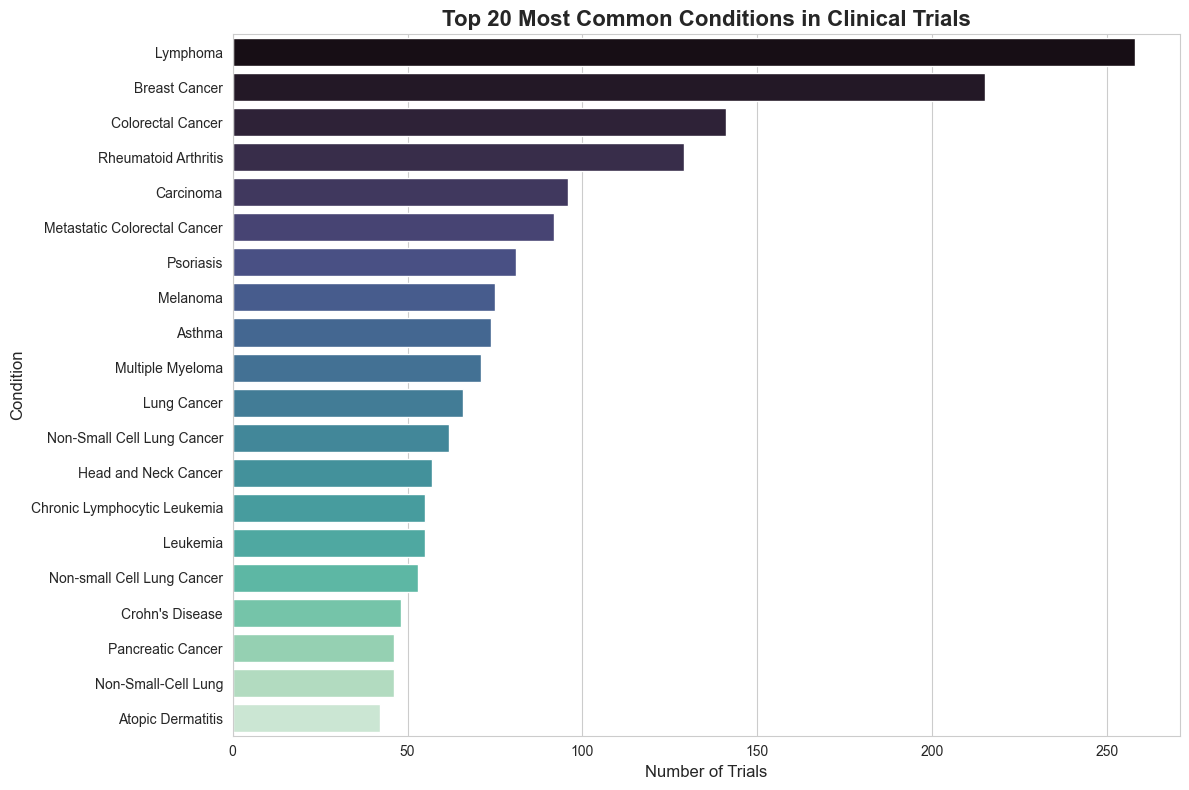

Lymphoma                        258
Breast Cancer                   215
Colorectal Cancer               141
Rheumatoid Arthritis            129
Carcinoma                        96
Metastatic Colorectal Cancer     92
Psoriasis                        81
Melanoma                         75
Asthma                           74
Multiple Myeloma                 71
Lung Cancer                      66
Non-Small Cell Lung Cancer       62
Head and Neck Cancer             57
Chronic Lymphocytic Leukemia     55
Leukemia                         55
Non-small Cell Lung Cancer       53
Crohn's Disease                  48
Pancreatic Cancer                46
Non-Small-Cell Lung              46
Atopic Dermatitis                42
Name: count, dtype: int64


In [12]:
# Extract individual conditions
all_conditions = []
for conditions in df['conditions'].dropna():
    all_conditions.extend([c.strip() for c in conditions.split(',')])

condition_counts = pd.Series(all_conditions).value_counts()

print(f"Total unique conditions: {len(condition_counts)}")
print(f"\nTop 20 Most Common Conditions:")

# Plot top 20 conditions
plt.figure(figsize=(12, 8))
top_conditions = condition_counts.head(20)
sns.barplot(y=top_conditions.index, x=top_conditions.values, hue=top_conditions.index, palette='mako', legend=False)
plt.title('Top 20 Most Common Conditions in Clinical Trials', fontsize=16, fontweight='bold')
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Condition', fontsize=12)
plt.tight_layout()
plt.show()

print(top_conditions)

## 9. Intervention Type Analysis

In [13]:
if 'intervention_types' not in df.columns:
    print('Intervention type metadata is not available in the local dataset.')
else:
    intervention_series = df['intervention_types'].dropna()
    if intervention_series.empty:
        print('Intervention type metadata is not available in the local dataset.')
    else:
        all_interventions = []
        for interventions in intervention_series:
            all_interventions.extend([i.strip() for i in interventions.split(',') if i.strip()])

        intervention_counts = pd.Series(all_interventions).value_counts()
        print('Intervention Type Distribution:')
        print(intervention_counts)

        plt.figure(figsize=(10, 6))
        colors = sns.color_palette('husl', len(intervention_counts))
        plt.pie(intervention_counts.values, labels=intervention_counts.index,
                autopct='%1.1f%%', startangle=90, colors=colors)
        plt.title('Distribution of Intervention Types', fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()


Intervention type metadata is not available in the local dataset.


## 10. Antibody-Specific Insights Summary

In [ ]:
print("=" * 70)
print("KEY INSIGHTS FROM ANTIBODY TRIAL EXPLORATION")
print("=" * 70)

print(f"\n1. Dataset Overview:")
print(f"   - Total antibody trials: {len(df):,} (Clean Labels - admin terminations excluded)")
print(f"   - Features collected: {len(df.columns)}")
if 'start_date' in df.columns:
    df['start_date_parsed_temp'] = pd.to_datetime(df['start_date'], errors='coerce')
    df['start_year_temp'] = df['start_date_parsed_temp'].dt.year
    print(f"   - Date range: {df['start_year_temp'].min():.0f} - {df['start_year_temp'].max():.0f}")
    df = df.drop(columns=['start_date_parsed_temp', 'start_year_temp'])

print(f"\n2. Antibody Types:")
if 'antibody_type' in df.columns:
    antibody_pct = df['antibody_type'].value_counts(normalize=True) * 100
    for ab_type, pct in antibody_pct.items():
        print(f"   - {ab_type}: {pct:.1f}%")

print(f"\n3. Trial Outcomes (Binary Labels):")
if 'binary_outcome' in df.columns:
    print(f"   - Successful (1): {(df['binary_outcome'] == 1).sum():,} ({(df['binary_outcome'] == 1).sum() / len(df) * 100:.1f}%)")
    print(f"   - Failed (0): {(df['binary_outcome'] == 0).sum():,} ({(df['binary_outcome'] == 0).sum() / len(df) * 100:.1f}%)")

print(f"\n4. Trial Status Distribution:")
if 'overall_status' in df.columns:
    status_counts = df['overall_status'].value_counts()
    for status, count in status_counts.items():
        print(f"   - {status}: {count:,} ({count / len(df) * 100:.1f}%)")

print(f"\n5. Phase Distribution:")
if 'phases' in df.columns:
    phase_pct = df['phases'].value_counts(normalize=True) * 100
    for phase, pct in phase_pct.head(5).items():
        print(f"   - {phase}: {pct:.1f}%")
elif 'phase' in df.columns:
    phase_pct = df['phase'].value_counts(normalize=True) * 100
    for phase, pct in phase_pct.head(5).items():
        print(f"   - {phase}: {pct:.1f}%")

print(f"\n6. Sponsor Insights:")
if 'sponsor_class' in df.columns:
    sponsor_pct = df['sponsor_class'].value_counts(normalize=True) * 100
    for sponsor, pct in sponsor_pct.items():
        print(f"   - {sponsor}: {pct:.1f}%")

print(f"\n7. Enrollment:")
if 'enrollment' in df.columns:
    print(f"   - Median enrollment: {df['enrollment'].median():.0f}")
    print(f"   - Mean enrollment: {df['enrollment'].mean():.0f}")
    print(f"   - Max enrollment: {df['enrollment'].max():.0f}")

print("\n" + "=" * 70)
print("LABELING STRATEGY:")
print("=" * 70)
print("✓ Using Clean Labels approach (excludes administrative terminations)")
print("✓ Focus: Predict clinical/efficacy success, not funding/enrollment issues")
print("✓ Excluded: 879 trials terminated for funding, enrollment, or business reasons")
print("✓ See docs/LABELING_STRATEGY_DECISION.md for experimental validation")

## 11. Save Processed Data

In [15]:
# Save the explored antibody dataset
df.to_csv('../data/antibody_trials_explored.csv', index=False)
print("Antibody data saved to ../data/antibody_trials_explored.csv")
print(f"\nDataset ready for labeling and feature engineering!")

Antibody data saved to ../data/antibody_trials_explored.csv

Dataset ready for labeling and feature engineering!


## 12. Cross-Analysis: Phase vs Status

Phase vs Status (% within each phase):
overall_status   Completed  Suspended  Terminated  Withdrawn
phases                                                      
Phase 1/Phase 2      61.22       0.89       28.05       9.84
Phase 2              70.48       0.43       20.61       8.47
Phase 2/Phase 3      71.95       2.44       17.68       7.93
Phase 3              79.92       0.33       15.73       4.02


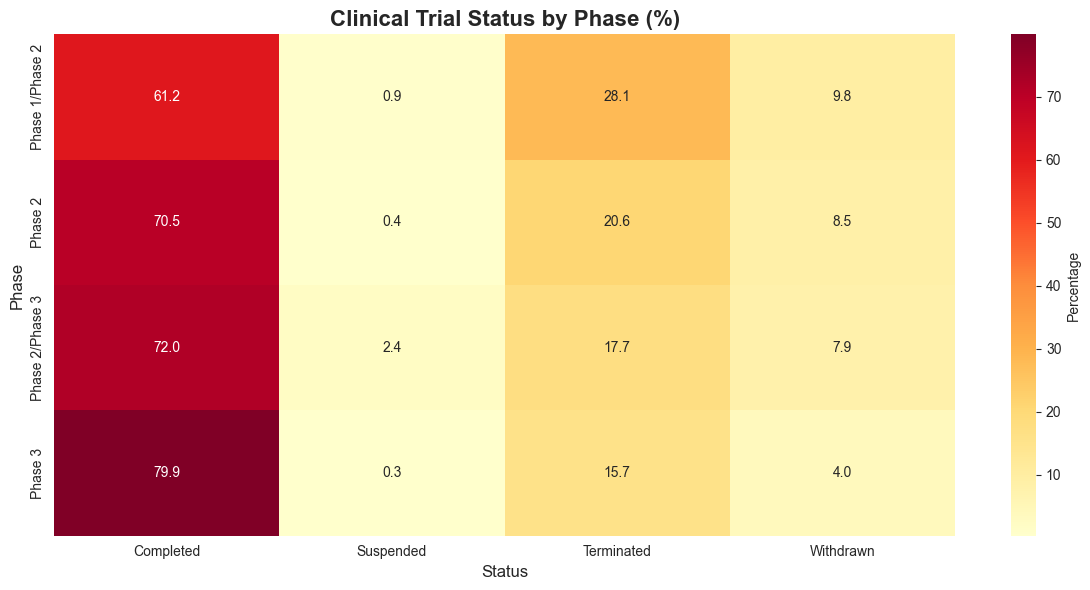

In [16]:
# Create crosstab
phase_status_crosstab = pd.crosstab(df['phases'], df['overall_status'], normalize='index') * 100

print("Phase vs Status (% within each phase):")
print(phase_status_crosstab.round(2))

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(phase_status_crosstab, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
plt.title('Clinical Trial Status by Phase (%)', fontsize=16, fontweight='bold')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Phase', fontsize=12)
plt.tight_layout()
plt.show()